Библиотеки

In [ ]:
# Работа с df
import pandas as pd
# Препроцессинг
pip install num2words
import num2words
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add('and')
# Кластеризация
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
# Визуализация
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
df = pd.read_json("Descriptions.json")
texts = df["Descriptions(1)"].to_list()

Препроцессинг
1.   Уберем стоп-слова, пунктуацию
2.   Переведем в нижний регистр, цифры в слова

In [ ]:
def preprocess_texts(texts):
    processed_texts = []
    for text in texts:
        text = text.lower()
        text = text.translate(text.maketrans("", "", string.punctuation))
        words = text.split()
        words = [num2words.num2words(int(word)) if word.isdigit() else word for word in words]
        words = [word for word in words if word not in stop_words]
        processed_texts.append(' '.join(words))
    return processed_texts
texts = preprocess_texts(texts)

Кластеризация

In [ ]:
# Tf-Idf
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(texts)
# получили векторы и положили в матрицу
# Кластеризируем матрицу с помощью алгоритма k-means 
clusters = 2
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(matrix)
labels = kmeans.predict(matrix)

Характеристики кластеров

In [ ]:
def most_common_words(cluster_id):
    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]
    words = ' '.join(cluster_texts).split()
    return Counter(words).most_common(10)
def mean_length(cluster_id):
    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]
    return np.mean([len(text) for text in cluster_texts])

cluster_sizes = Counter(labels)
for cluster_id in range(clusters):
    print(f"Cluster {cluster_id}:")
    print(f"- Size: {cluster_sizes[cluster_id]}")
    print(f"- Most common words: {most_common_words(cluster_id)}")
    print(f"- Average text length: {mean_length(cluster_id)}")

Cluster 0:
- Size: 253
- Most common words: [('miles', 955), ('dublin', 783), ('airport', 510), ('apartment', 391), ('free', 342), ('nearest', 250), ('property', 248), ('city', 238), ('museum', 227), ('accommodation', 226)]
- Average text length: 538.6245059288538
Cluster 1:
- Size: 166
- Most common words: [('dublin', 341), ('hotel', 318), ('rooms', 227), ('walk', 222), ('bar', 213), ('free', 175), ('street', 140), ('away', 140), ('city', 136), ('offers', 136)]
- Average text length: 677.0903614457832


**По тематике**:\
Cluster 0 связан с географией отелей, особенно близостью к аэропорту. Наиболее распространенные уникальные слова относятся к особенностям расположения в Дублине, например, 'miles', 'airport', 'nearest'.\
Cluster 1 связан с характеристикой отелей. Наиболее распространенные уникальные слова относятся к внутренним особенностям пребывания в отелях в Дублине, например, 'rooms', 'bar', 'walk', 'offers'. \
**По размеру**:\
Cluster 0 содержит гораздо больше элементов чем Cluster 1 соответственно отели чаще предпочитают отдавать приоритет информации о расположении, чем об оснащении.\
**По средней длине текста:**\
Средняя длина текстов в Cluster 0(538.6) меньше,  чем в Cluster 1(677.1), что указывает на то, что в описаниях с фокусом на характеристики отеля, предпочитают использовать более подробную информацию по сравнению с описаниями с фокусом на расположение отеля. 

Визуализация

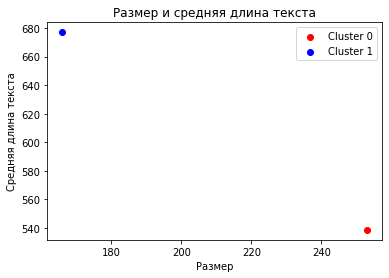

In [ ]:
cluster_0 = [253, 538.6245059288538]
cluster_1 = [166, 677.0903614457832]
plt.scatter(cluster_0[0], cluster_0[1], c='red', label='Cluster 0')
plt.scatter(cluster_1[0], cluster_1[1], c='blue', label='Cluster 1')
plt.title("Размер и средняя длина текста")
plt.xlabel("Размер")
plt.ylabel("Средняя длина текста")
plt.legend()
plt.show()

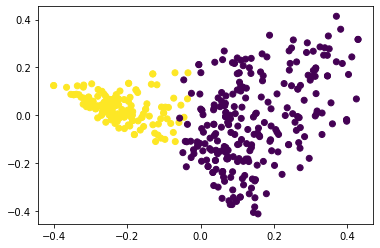

In [ ]:
# PCA
pca = PCA(clusters)
plot_pca = pca.fit_transform(matrix.toarray())
plt.scatter(plot_pca[:, 0], plot_pca[:, 1], c=labels)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


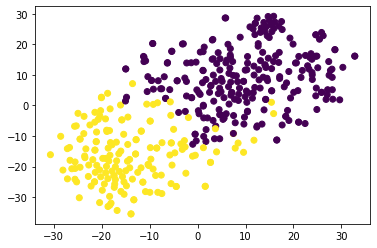

In [ ]:
# TSNE
tsne = TSNE(clusters)
plot_tsne = tsne.fit_transform(matrix.toarray())
plt.scatter(plot_tsne[:, 0], plot_tsne[:, 1], c=labels)
plt.show()

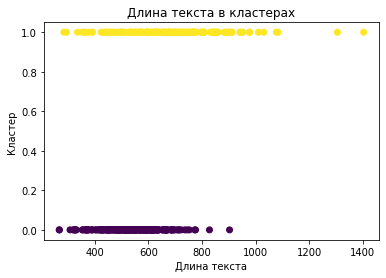

In [ ]:
# Длина текстов
texts_lengths = [len(text) for text in texts]
plt.scatter(texts_lengths, labels, c=labels)
plt.title("Длина текста в кластерах")
plt.xlabel("Длина текста")
plt.ylabel("Кластер")
plt.show()

Сохраняем

In [ ]:
feature_names = vectorizer.get_feature_names()
most_important_words = []
for text in matrix:
    word_importance = np.array(text.todense().tolist()[0])
    most_important_word = feature_names[np.argmax(word_importance)]
    most_important_words.append(most_important_word)
df = pd.DataFrame({'Text': texts, 'Length': texts_lengths, 'Cluster': labels, 'Most Important Word': most_important_words})
df.to_json("cluster_data.json")
df.to_csv("cluster_data.csv")
df.to_excel("cluster_data.xlsx")